In [61]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import time
import joblib
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

from utility import get_imsd, get_imsd_windowed, get_emsd, get_emsd_windowed, fit_hist, MB_2D,\
                    normal_distr, lorentzian_distr, get_trajs, speed_windowed, theta_windowed, \
                    get_smooth_trajs, get_velocities, powerLawFit

In [62]:
traj_verb = "hough"

if traj_verb == "trackpy": 
    rawTrajs = pd.read_parquet("../../tracking/results/tracking_data/trackpy_pre_merge.parquet")
    nDrops = int(len(rawTrajs.loc[rawTrajs.frame==0]))
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, 30, 2)

    res_path = "results"
    analysis_data_path = "analysis_data"

elif traj_verb == "hough":
    rawTrajs = pd.read_parquet("../../tracking/results/tracking_data/tracking_hough_trackpy_linking.parquet")
    nDrops = int(len(rawTrajs.loc[rawTrajs.frame==0]))
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, 30, 2)

    res_path = "hough_results"
    analysis_data_path = "hough_analysis_data"
else:
    raise ValueError("traj_verb must be either 'trackpy' or 'hough'")

red_particle_idx = 17
colors = rawTrajs.loc[rawTrajs.frame == 0, 'color'].values
nFrames = int(max(rawTrajs.frame) + 1)
fps = 10
print(f"Number of Droplets: {nDrops}")
print(f"Number of Frames: {nFrames} at {fps} fps --> {nFrames/10:.2f} s")

# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print("Windowed analysis args:")

startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"window of {window/10} s, stride of {stride/10} s --> {nSteps} steps")

# step 10 with a 10 fps video --> 1 s
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

Number of Droplets: 50
Number of Frames: 32000 at 10 fps --> 3200.00 s
Windowed analysis args:
window of 320.0 s, stride of 10.0 s --> 288 steps


In [105]:
class MSD_analysis:
    def __init__(self, _traj_type, _pxDimension, _fps, _maxLagtime):
        self.traj_type = _traj_type
        if self.traj_type == "raw":
            self.trajectories = rawTrajs
            self.red_droplet_id = 17
        elif self.traj_type == "smooth":
            self.trajectories = smoothTrajs
            self.red_droplet_id = 17
        else:
            raise ValueError("traj_type must be either 'raw' or 'smooth'")
        self.pxDimension = _pxDimension # has to be defined 
        self.fps = _fps # fps of the video
        self.maxLagtime = _maxLagtime # maximum lagtime to be considered
        self.nDrops = len(self.trajectories.loc[self.trajectories.frame==0])
        self.col = ['blue' for i in range(nDrops)]
        self.col[self.red_droplet_id] = 'red'
        self.imsd, self.imsd_fit, self.imsd_pw_law = None, None, None
        self.imsd_fit, self.imsd_pw_law = None, None
        self.emsd, self.emsd_windowed = None, None
        
    def compute_imsd(self, trajectory):
        print("Computing imsd...")
        self.imsd = tp.imsd(trajectory, self.pxDimension, self.fps, self.maxLagtime)
        #print(self.imsd[1:])
        self.imsd_fit, self.imsd_pw_law = powerLawFit(self.imsd[1:], self.imsd[1:].index, self.nDrops, None)
        
        
    def imsd_plot(self, save_verb, show_verb):
        if self.imsd is None:
            self.compute_imsd()

        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8, 5), tight_layout=True)
        ax1 = fig.add_subplot(gs[0, :])
        for i in range(nDrops):
            ax1.plot(self.imsd.index, self.imsd.values[:, i], color = self.col[i], linewidth = 0.5)
        ax1.set(xscale="log", yscale = "log", xlabel = "lag time [s]", ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',\
                title = f"IMSD - {self.traj_type} trajectories")
        ax1.grid()
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.scatter(np.arange(self.nDrops), self.imsd_pw_law[:, 0, 1], s = 10,  color = self.col)
        ax2.set(xlabel = "Droplet ID", ylabel = r"$\alpha$", title = "power law exponents")
        ax2.grid()
        ax3 = fig.add_subplot(gs[1, 1])
        ax3.scatter(np.arange(self.nDrops), self.imsd_pw_law[:, 0, 0], s = 10, color = self.col)
        ax3.set(xlabel="Droplet ID", ylabel = "K", title = "Diffusion coefficients")
        ax3.grid()
        if save_verb: plt.savefig(f"./{res_path}/mean_squared_displacement/IMSD_{self.traj_type}_v2.png", bbox_inches='tight')
        if show_verb:
            plt.show()
        else:
            plt.close()
    
    def compute_emsd(self):
        print("Computing emsd...")
        if self.imsd is None:
            self.compute_imsd()
        MSD = np.array(self.imsd)
        self.emsd_b = [MSD[:, [x for x in range(self.nDrops) if x != self.red_droplet_id]].mean(axis = 1),
                    MSD[:,[x for x in range(self.nDrops) if x != self.red_droplet_id]].std(axis = 1)]
        self.emsd_r = MSD[:, self.red_droplet_id]
        # fit the diffusive region of the MSD
        fit_b, pw_exp_b = powerLawFit(self.emsd_b[0][9:], np.arange(1, 100.1, 0.1), 1, self.emsd_b[1][9:])
        fit_r, pw_exp_r = powerLawFit(self.emsd_r[9:], np.arange(1, 100.1, 0.1), 1, None)
        self.emsd_results = {"fit_b":fit_b, "pw_exp_b":pw_exp_b, "fit_r":fit_r, "pw_exp_r":pw_exp_r}

        alpha_b = [round(pw_exp_b[0, 1], 3), round(pw_exp_b[1, 1], 3)]
        k_b = [round(pw_exp_b[0, 0], 3), round(pw_exp_b[1, 0], 3)]
        alpha_r = [round(pw_exp_r[0, 1], 3), round(pw_exp_r[1, 1], 3)]
        k_r = [round(pw_exp_r[0, 0], 3), round(pw_exp_r[1, 0], 3)]
        print(f"{self.traj_type} trajs - Blue droplets: a = {alpha_b[0]} ± {alpha_b[1]}, K = {k_b[0]} ± {k_b[1]}")
        print(f"{self.traj_type} trajs - Red droplet: a = {alpha_r[0]} ± {alpha_r[1]}, K = {k_r[0]} ± {k_r[1]}")

    def emsd_plot(self, save_verb, show_verb):

        if self.emsd_b is None or self.emsd_r is None:
            self.compute_emsd()
        fig, ax = plt.subplots(1, 1, figsize = (10, 4))
        ax.plot(self.imsd.index, self.emsd_b [0], 'b-', label = "Blue droplets") 
        ax.plot(self.imsd[1:].index, self.emsd_results["fit_b"], 'b--')
        ax.fill_between(self.imsd.index, self.emsd_b[0] - self.emsd_b[1], self.emsd_b[0] + self.emsd_b[1], alpha=0.5,\
                        edgecolor='#00FFFF', facecolor='#F0FFFF')
        ax.plot(self.imsd.index, self.emsd_r, 'r-', label = "Red droplet")
        ax.plot(self.imsd[1:].index, self.emsd_results["fit_r"], 'r--')
        ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',   
                xlabel = 'lag time $t$ [s]', title = f"EMSD - {self.traj_type} Trajectories")
        ax.legend()
        ax.grid()
        if save_verb: plt.savefig(f"./{res_path}/mean_squared_displacement/EMSD_{self.traj_type}.png", bbox_inches='tight')
        if show_verb:
            plt.show()
        else:
            plt.close()

    def compute_windowed_imsd(self, window_size, stride):
        print("Computing windowed imsd...")

        # diffusive region of the MSD
        fit_wind = np.zeros((nSteps, nDrops, self.maxLagtime-9))
        pw_exp_wind = np.zeros((nSteps, nDrops, 2, 2))
        for i in tqdm(range(nSteps)):
            trajs_wind = self.trajectories.loc[self.trajectories.frame.between(startFrames[i], endFrames[i])]
            temp, fit_wind[i], pw_exp_wind[i] = self.compute_imsd()
            MSD_wind.append(temp)

In [ ]:
MSD_analysis_raw = MSD_analysis("raw", 1, 10, 1000)

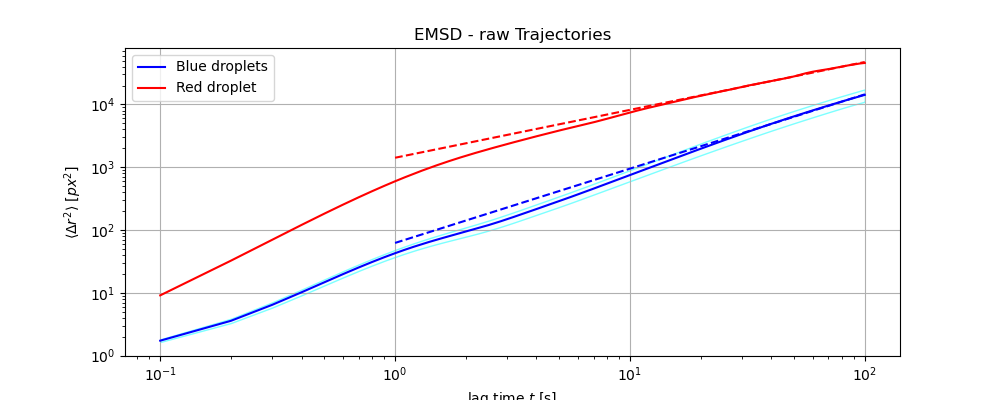

In [108]:
#MSD_analysis_raw.compute_imsd()
#MSD_analysis_raw.imsd_plot(save_verb = False, show_verb = True)
#MSD_analysis_raw.compute_emsd()
MSD_analysis_raw.emsd_plot(save_verb = False, show_verb = True)

In [109]:
MSD_analysis_smooth = MSD_analysis("smooth", 1, 10, 1000)

/var/folders/8x/m08xmk_178vd007wy7lbx80w0000gn/T/ipykernel_7541/1055839052.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize = (10, 4))


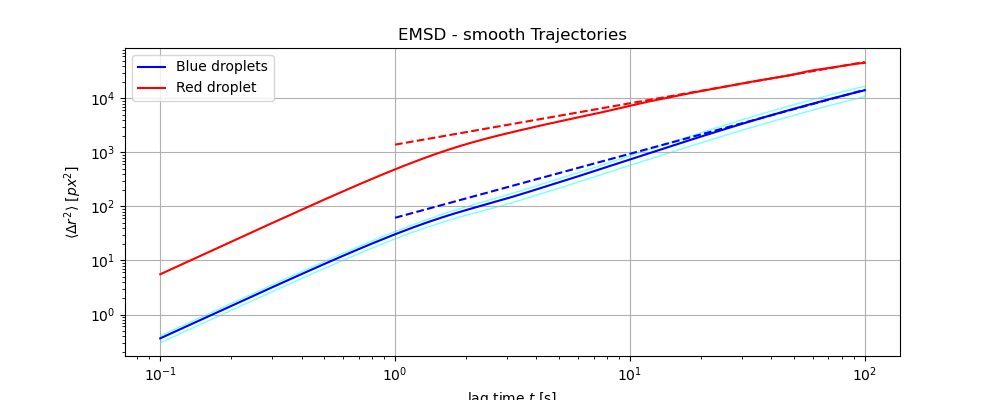

In [112]:
#MSD_analysis_smooth.compute_imsd()
#MSD_analysis_smooth.imsd_plot(save_verb=False, show_verb=True)
#MSD_analysis_smooth.compute_emsd()
MSD_analysis_smooth.emsd_plot(save_verb=False, show_verb=True)